<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/WrapUp/pred_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **수익률 예측값을 활용하여 최적의 포트폴리오 찾기**

- 데이터: 보험사 대장주 5종목의 10년치 데이터
    
    - 2015-01-01부터 2023-12-31까지 9년치 데이터를 학습용(Train)으로 설정
    
    - 2024-01-01부터 마지막 데이터(2024-12-31)까지 1년치를 테스트용(Test)으로 설정
- 시도해본 모델: 통계 시계열 (ARIMA), 구조적 시계열(Prophet), 딥러닝 시계열 (LSTM)
- 평가지표: MAE, RMSE
    
    => **ARIMA**가 LSTM보다 높은 예측 정확도를 보였다. 변동성이 크지 않은 대형 보험주들의 경우 선형적인 패턴을 잘 잡아내는 ARIMA가 유리할 수 있다는 것을 확인했다.
- **몬테카를로 시뮬레이션**: 10,000번의 무작위 비중 조합을 만들어 각 조합의 예상 수익률과 위험을 계산했다.
- **샤프 지수** (Sharp Ratio): 위험 대비 수익이 가장 높은 포트폴리오를 찾았다.

In [6]:
!pip install finance-datareader statsmodels tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [8]:
# 종목 설정 (삼성생명, 삼성화재, DB손해보험, 현대해상, 한화생명)
# 각 코드에 맞게 이름을 매칭하여 나중에 보기 편하게 만듭니다.
ticker_dict = {
    '삼성생명': '032830',
    '삼성화재': '000810',
    'DB손해보험': '005830',
    '현대해상': '001450',
    '한화생명': '088350'
}

tickers = list(ticker_dict.values())
stock_names = list(ticker_dict.keys())

# 데이터 불러오기
data = pd.DataFrame()
for t in tickers:
    # 2015년부터 10년치 데이터를 기준으로 'Close(종가)' 컬럼만 가져옵니다.
    data[t] = fdr.DataReader(t, '2015-01-01', '2024-12-31')['Close']

# 컬럼명을 종목 코드가 아닌 한글 이름으로 변경 (가독성용)
data.columns = stock_names

print("--- 데이터 로드 완료 ---")
print(data.head())

--- 데이터 로드 완료 ---
              삼성생명    삼성화재  DB손해보험   현대해상  한화생명
Date                                           
2015-01-02  115000  285000   54900  26000  7950
2015-01-05  117000  286000   54100  26100  7750
2015-01-06  115500  290500   54000  26750  7670
2015-01-07  117500  296500   53300  26700  7660
2015-01-08  120000  300500   53400  26700  7740


1) 과거 데이터로 포트폴리오를 분석

In [9]:
# --- 일간 & 연간 수익률 계산 ---
daily_ret = data.pct_change()
annual_ret = daily_ret.mean() * 252
print("연간 평균 수익률:\n", annual_ret)

# --- 연간 분산/공분산 (위험도) ---
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252
print("\n연간 공분산:\n", annual_cov)

연간 평균 수익률:
 삼성생명      0.028857
삼성화재      0.069080
DB손해보험    0.123464
현대해상      0.045568
한화생명     -0.050011
dtype: float64

연간 공분산:
             삼성생명      삼성화재    DB손해보험      현대해상      한화생명
삼성생명    0.098644  0.050028  0.045998  0.040862  0.061011
삼성화재    0.050028  0.091392  0.058801  0.051732  0.046149
DB손해보험  0.045998  0.058801  0.118880  0.074799  0.056383
현대해상    0.040862  0.051732  0.074799  0.101825  0.051126
한화생명    0.061011  0.046149  0.056383  0.051126  0.144692


In [10]:
# --- 몬테카를로 시뮬레이션 ---
stocks = data.columns.tolist()  # 종목명 리스트
simulations = 10000
box = []
for i in range(simulations):
    w = np.random.random(len(stocks))
    w /= sum(w)
    ret = np.dot(w, annual_ret)
    risk = np.sqrt(np.dot(w.T, np.dot(annual_cov, w)))
    sharpe = ret / risk if risk > 0 else 0
    box.append([ret, risk, sharpe] + list(w))

# 결과 저장
cols = ['Returns', 'Risk', 'Sharpe'] + stocks
results = pd.DataFrame(box, columns=cols)
print("\nSimulation Results Sample:\n", results.head())


Simulation Results Sample:
     Returns      Risk    Sharpe      삼성생명      삼성화재    DB손해보험      현대해상  \
0  0.029920  0.253841  0.117870  0.247529  0.293179  0.049896  0.176170   
1  0.051674  0.256458  0.201492  0.266865  0.230541  0.266062  0.073526   
2  0.034931  0.278645  0.125359  0.196910  0.041754  0.356957  0.026325   
3  0.063746  0.259361  0.245782  0.324418  0.109068  0.309182  0.225432   
4  0.045467  0.250445  0.181546  0.302593  0.271409  0.093815  0.240810   

       한화생명  
0  0.233225  
1  0.163006  
2  0.378054  
3  0.031900  
4  0.091373  


In [11]:
# --- 최대 샤프 & 최소 리스크 포트폴리오 ---
# Sharpe나 Risk 컬럼에 NaN이 있으면 행을 제거합니다.
clean_results = results.dropna(subset=['Sharpe', 'Risk'])

# 제거 후 데이터가 남아있는지 확인하고 계산합니다.
max_sharpe = results.loc[results['Sharpe'].idxmax()]
min_risk = results.loc[results['Risk'].idxmin()]
print("\nMax Sharpe Portfolio:\n", max_sharpe)
print("\nMin Risk Portfolio:\n", min_risk)


Max Sharpe Portfolio:
 Returns    0.100118
Risk       0.292464
Sharpe     0.342325
삼성생명       0.075193
삼성화재       0.240663
DB손해보험     0.659438
현대해상       0.011944
한화생명       0.012763
Name: 6522, dtype: float64

Min Risk Portfolio:
 Returns    0.043836
Risk       0.250364
Sharpe     0.175088
삼성생명       0.287581
삼성화재       0.280449
DB손해보험     0.069036
현대해상       0.269838
한화생명       0.093096
Name: 7226, dtype: float64


# 2) ARIMA (통계 기반) 예측

미래 수익률을 예측 → 예측 기반 포트폴리오 구성 (이제 과거 평균이 아닌, 예측 수익률을 사용)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
# 로그 수익률 생성 (예측용)
log_ret = np.log(data / data.shift(1)).dropna()

In [14]:
# Train / Test 분리
train = log_ret.loc['2015-01-01':'2023-12-31']
test  = log_ret.loc['2024-01-01':]

In [15]:
# ARIMA 예측 함수
def arima_forecast(train_series, test_series):
    model = ARIMA(train_series, order=(1,0,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    return forecast

# 종목별 예측 및 평가
arima_preds = {}
arima_scores = {}

for stock in train.columns:
    pred = arima_forecast(train[stock], test[stock])

    mae = mean_absolute_error(test[stock], pred)
    rmse = np.sqrt(mean_squared_error(test[stock], pred))

    arima_preds[stock] = pred
    arima_scores[stock] = {'MAE': mae, 'RMSE': rmse}

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [16]:
arima_scores = pd.DataFrame(arima_scores).T
print("ARIMA 예측 정확도")
print(arima_scores)

ARIMA 예측 정확도
             MAE      RMSE
삼성생명    0.020278  0.027707
삼성화재    0.021123  0.028857
DB손해보험  0.021077  0.027665
현대해상    0.015886  0.021272
한화생명    0.017384  0.023372


**해석 포인트:**
- MAE ↓, RMSE ↓ → 예측 성능 우수
- 종목별 변동성 차이 반영됨

# ARIMA 예측 기반 포트폴리오

In [17]:
forecast_ret_arima = {}
for stock in arima_preds:
    # 테스트 기간 동안의 평균 예측 수익률을 연간 수익률로 변환
    forecast_ret_arima[stock] = np.mean(arima_preds[stock]) * 252

forecast_ret_arima = pd.Series(forecast_ret_arima)
print("\n--- ARIMA 기반 연간 예측 수익률 ---")
print(forecast_ret_arima)


--- ARIMA 기반 연간 예측 수익률 ---
삼성생명     -0.058273
삼성화재     -0.010979
DB손해보험    0.046330
현대해상      0.018430
한화생명     -0.116931
dtype: float64


In [18]:
# 리스크 계산을 위한 공분산 행렬 (Train 데이터 기준)
annual_cov = train.cov() * 252

In [19]:
# --- 2. 예측 기반 몬테카를로 시뮬레이션 ---
simulations = 10000
arima_box = []
stocks = forecast_ret_arima.index.tolist()

for _ in range(simulations):
    # 가중치 랜덤 생성 및 정규화
    w = np.random.random(len(stocks))
    w /= w.sum()

    # 포트폴리오 기대 수익률 및 리스크 계산
    ret = np.dot(w, forecast_ret_arima)
    risk = np.sqrt(np.dot(w.T, np.dot(annual_cov, w)))
    sharpe = ret / risk if risk > 0 else 0

    arima_box.append([ret, risk, sharpe] + list(w))

# 결과 데이터프레임 생성
cols = ['Returns', 'Risk', 'Sharpe'] + stocks
arima_pf = pd.DataFrame(arima_box, columns=cols)
print("\nSimulation Results Sample:\n", arima_pf.head())


Simulation Results Sample:
     Returns      Risk    Sharpe      삼성생명      삼성화재    DB손해보험      현대해상  \
0 -0.022680  0.250888 -0.090400  0.182277  0.102234  0.289500  0.188112   
1 -0.016213  0.249824 -0.064898  0.066022  0.225362  0.215431  0.279228   
2 -0.034256  0.238596 -0.143572  0.380098  0.393817  0.076693  0.045310   
3 -0.027931  0.261511 -0.106805  0.033260  0.138997  0.254726  0.227066   
4 -0.016595  0.240693 -0.068946  0.191926  0.242063  0.195735  0.232530   

       한화생명  
0  0.237877  
1  0.213958  
2  0.104082  
3  0.345952  
4  0.137746  


In [20]:
# --- 3. 최적 포트폴리오 찾기 (Max Sharpe & Min Risk) ---
best_arima = arima_pf.loc[arima_pf['Sharpe'].idxmax()]
min_risk_arima = arima_pf.loc[arima_pf['Risk'].idxmin()]

print("\n[ARIMA 기반 최대 샤프 포트폴리오]")
print(best_arima)


[ARIMA 기반 최대 샤프 포트폴리오]
Returns    0.032084
Risk       0.294353
Sharpe     0.109000
삼성생명       0.006915
삼성화재       0.056223
DB손해보험     0.664014
현대해상       0.252995
한화생명       0.019853
Name: 5947, dtype: float64


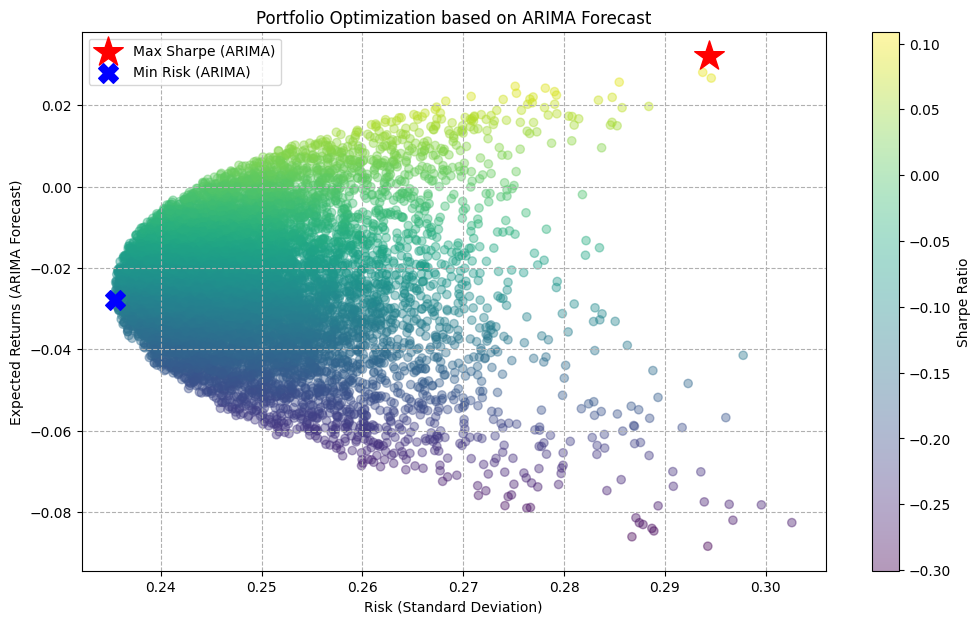

In [21]:
# --- 4. 시각화 ---
plt.figure(figsize=(12, 7))

# 몬테카를로 시뮬레이션 결과 점들
scatter = plt.scatter(arima_pf['Risk'], arima_pf['Returns'],
                      c=arima_pf['Sharpe'], cmap='viridis', alpha=0.4)
plt.colorbar(scatter, label='Sharpe Ratio')

# 최대 샤프 포트폴리오 표시 (별표)
plt.scatter(best_arima['Risk'], best_arima['Returns'],
            marker='*', color='red', s=500, label='Max Sharpe (ARIMA)')

# 최소 리스크 포트폴리오 표시 (X표)
plt.scatter(min_risk_arima['Risk'], min_risk_arima['Returns'],
            marker='X', color='blue', s=200, label='Min Risk (ARIMA)')

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Returns (ARIMA Forecast)')
plt.title('Portfolio Optimization based on ARIMA Forecast')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# 3) LSTM 기반 수익률 예측
- 비선형 패턴 학습 가능
- 단기 예측에서 ARIMA보다 유리한 경우 많음

In [22]:
# 시계열 데이터셋 생성 함수
def make_lstm_dataset(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

# LSTM 학습 & 예측
lstm_preds = {}
lstm_scores = {}

window = 20

for stock in train.columns:
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train[[stock]])
    scaled_test  = scaler.transform(test[[stock]])

    X_train, y_train = make_lstm_dataset(scaled_train, window)
    X_test, y_test   = make_lstm_dataset(scaled_test, window)

    model = Sequential([
        LSTM(50, input_shape=(window, 1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)

    true = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(true, pred_inv)
    rmse = np.sqrt(mean_squared_error(true, pred_inv))

    lstm_preds[stock] = pred_inv.flatten()
    lstm_scores[stock] = {'MAE': mae, 'RMSE': rmse}

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [23]:
lstm_scores = pd.DataFrame(lstm_scores).T
print("LSTM 예측 정확도")
print(lstm_scores)

LSTM 예측 정확도
             MAE      RMSE
삼성생명    0.021296  0.028808
삼성화재    0.022611  0.030554
DB손해보험  0.022115  0.028603
현대해상    0.016407  0.022004
한화생명    0.017411  0.023547


# LSTM 예측 기반 포트폴리오

In [24]:
# 예측 수익률 생성
forecast_ret_lstm = {}

for stock in lstm_preds:
    forecast_ret_lstm[stock] = np.mean(lstm_preds[stock]) * 252

forecast_ret_lstm = pd.Series(forecast_ret_lstm)
print("LSTM 기반 연간 예측 수익률")
print(forecast_ret_lstm)

LSTM 기반 연간 예측 수익률
삼성생명     -0.246202
삼성화재     -0.761636
DB손해보험   -0.183015
현대해상     -0.820504
한화생명      0.560710
dtype: float32


In [25]:
# 공분산은 Train 데이터 기준
annual_cov = train.cov() * 252

In [26]:
# --- 4. "예측 기반" 몬테카를로 시뮬레이션 ---
simulations = 10000
box = []
stocks = forecast_ret_lstm.index.tolist()  # 종목명 리스트
for _ in range(simulations):
    w = np.random.random(len(stocks))
    w /= w.sum()

    ret = np.dot(w, forecast_ret_lstm)
    risk = np.sqrt(np.dot(w.T, np.dot(annual_cov, w)))
    sharpe = ret / risk if risk > 0 else 0

    box.append([ret, risk, sharpe] + list(w))

# 결과 저장
cols = ['Returns', 'Risk', 'Sharpe'] + stocks
lstm_pf = pd.DataFrame(box, columns=cols)
print("\nSimulation Results Sample:\n", lstm_pf.head())


Simulation Results Sample:
     Returns      Risk    Sharpe      삼성생명      삼성화재    DB손해보험      현대해상  \
0 -0.292066  0.243693 -1.198501  0.170877  0.210287  0.145291  0.238026   
1 -0.237216  0.255968 -0.926744  0.012297  0.250136  0.317867  0.159883   
2 -0.036340  0.260852 -0.139312  0.160535  0.204394  0.116766  0.079923   
3 -0.463980  0.241592 -1.920512  0.193432  0.352527  0.260696  0.150996   
4 -0.550585  0.255128 -2.158072  0.007883  0.319442  0.192790  0.390337   

       한화생명  
0  0.235519  
1  0.259818  
2  0.438382  
3  0.042348  
4  0.089548  


In [27]:
# --- 5. 최대 샤프 & 최소 리스크 포트폴리오 ---
# Sharpe나 Risk 컬럼에 NaN이 있으면 행을 제거합니다.
clean_results = lstm_pf.dropna(subset=['Sharpe', 'Risk'])

# 예측 기반 최적 포트폴리오
best_lstm = lstm_pf.loc[lstm_pf['Sharpe'].idxmax()]
print("LSTM 기반 최대 샤프 포트폴리오")
print(best_lstm)

LSTM 기반 최대 샤프 포트폴리오
Returns    0.287866
Risk       0.308365
Sharpe     0.933525
삼성생명       0.248493
삼성화재       0.005273
DB손해보험     0.030983
현대해상       0.030637
한화생명       0.684614
Name: 447, dtype: float64


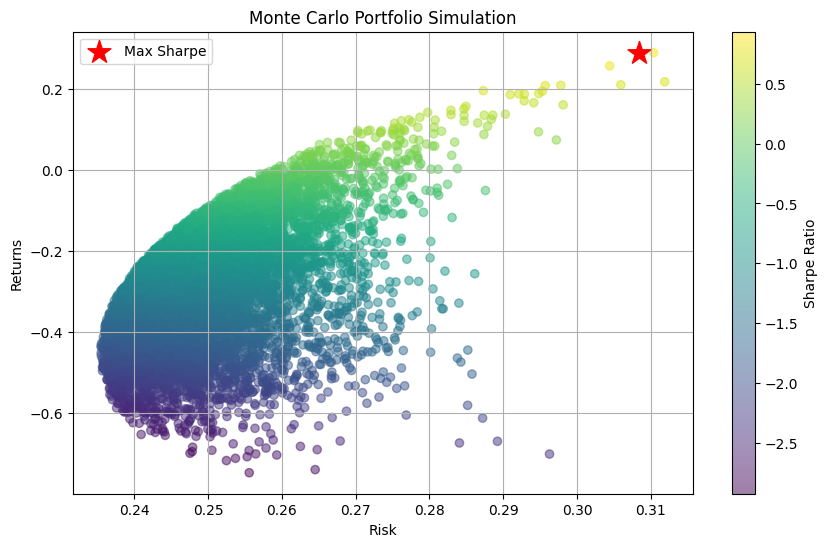

In [28]:
# --- 6. 시각화 ---
plt.figure(figsize=(10,6))
plt.scatter(lstm_pf['Risk'], lstm_pf['Returns'], c=lstm_pf['Sharpe'],
            cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(best_lstm['Risk'], best_lstm['Returns'],
            marker='*', color='r', s=300, label='Max Sharpe')
plt.xlabel('Risk')
plt.ylabel('Returns')
plt.title('Monte Carlo Portfolio Simulation')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# --- 7. (선택) KOSPI 지수 기본 통계 ---
kospi = fdr.DataReader('KOSPI')
print("\nKOSPI Data Head:\n", kospi.head())
print("\nKOSPI Max Close:", kospi['Close'].max())
print("KOSPI Min Close:", kospi['Close'].min())


KOSPI Data Head:
               Open    High     Low   Close     Volume  Change  UpDown   Comp  \
Date                                                                           
2001-06-11  612.46  615.41  607.20  608.23  340123834 -0.0218       2 -13.55   
2001-06-12  605.36  611.88  603.91  607.15  319877548 -0.0018       2  -1.08   
2001-06-13  611.79  614.05  607.48  614.05  392415108  0.0114       1   6.90   
2001-06-14  612.96  623.37  610.36  613.75  420520519 -0.0005       2  -0.30   
2001-06-15  609.54  618.96  604.37  618.96  375830101  0.0085       1   5.21   

                   Amount           MarCap  
Date                                        
2001-06-11  1711354887650  213769808029580  
2001-06-12  1579309434050  213407866089170  
2001-06-13  1882785913600  215722300556140  
2001-06-14  2138122210150  215864633350565  
2001-06-15  1984248114150  217830955673590  

KOSPI Max Close: 4586.32
KOSPI Min Close: 468.76


포트폴리오들을 시장 전체와 비교해본다.

# 4) Prophet 기반 수익률 예측
- Prophet은 복잡한 비선형 패턴을 학습할 필요 없이 추세·계절성을 기반으로 안정적 예측 가능
- 절성/이벤트를 추가 분석할 때 장점이 있다.
- 통계 모델과 머신러닝의 중간 성격의 구조적(Sructural) 시계열 모델

In [30]:
!pip install prophet

In [31]:
from prophet import Prophet

In [33]:
# Prophet용 데이터 전처리 (Prophet은 반드시 컬럼명이 ds, y여야 함)

# Prophet용 로그수익률 데이터 생성
log_ret = np.log(data / data.shift(1)).dropna()

# Train / Test 분리 (기존과 동일)
train = log_ret.loc['2015-01-01':'2023-12-31']
test  = log_ret.loc['2024-01-01':]

In [34]:
# Prophet 예측 함수
def prophet_forecast(train_series, test_series):
    # Prophet용 데이터프레임
    df_train = train_series.reset_index()
    df_train.columns = ['ds', 'y']

    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    )

    model.fit(df_train)

    # 미래 데이터프레임 생성
    future = model.make_future_dataframe(periods=len(test_series), freq='B')
    forecast = model.predict(future)

    # 예측값 중 Test 구간만 추출
    pred = forecast['yhat'].iloc[-len(test_series):].values
    return pred

In [35]:
# 종목별 Prophet 예측 + 성능 평가

prophet_preds = {}
prophet_scores = {}

for stock in train.columns:
    pred = prophet_forecast(train[stock], test[stock])

    mae = mean_absolute_error(test[stock], pred)
    rmse = np.sqrt(mean_squared_error(test[stock], pred))

    prophet_preds[stock] = pred
    prophet_scores[stock] = {'MAE': mae, 'RMSE': rmse}

prophet_scores = pd.DataFrame(prophet_scores).T
print("Prophet 예측 정확도")
print(prophet_scores)

Prophet 예측 정확도
             MAE      RMSE
삼성생명    0.020529  0.027898
삼성화재    0.021154  0.028832
DB손해보험  0.021073  0.027670
현대해상    0.015859  0.021383
한화생명    0.017565  0.023714


In [36]:
# Prophet 예측 기반 연간 수익률 생성

forecast_ret_prophet = {}

for stock in prophet_preds:
    forecast_ret_prophet[stock] = np.mean(prophet_preds[stock]) * 252

forecast_ret_prophet = pd.Series(forecast_ret_prophet)
print("\n--- Prophet 기반 연간 예측 수익률 ---")
print(forecast_ret_prophet)


--- Prophet 기반 연간 예측 수익률 ---
삼성생명     -0.002670
삼성화재      0.141200
DB손해보험    0.232837
현대해상     -0.025771
한화생명      0.122053
dtype: float64


In [37]:
# Prophet 기반 몬테카를로 시뮬레이션

# 공분산은 Train 데이터 기준 (기존과 동일)
annual_cov = train.cov() * 252

simulations = 10000
prophet_box = []
stocks = forecast_ret_prophet.index.tolist()

for _ in range(simulations):
    w = np.random.random(len(stocks))
    w /= w.sum()

    ret = np.dot(w, forecast_ret_prophet)
    risk = np.sqrt(np.dot(w.T, np.dot(annual_cov, w)))
    sharpe = ret / risk if risk > 0 else 0

    prophet_box.append([ret, risk, sharpe] + list(w))

cols = ['Returns', 'Risk', 'Sharpe'] + stocks
prophet_pf = pd.DataFrame(prophet_box, columns=cols)

print("\nProphet Simulation Sample")
print(prophet_pf.head())


Prophet Simulation Sample
    Returns      Risk    Sharpe      삼성생명      삼성화재    DB손해보험      현대해상  \
0  0.135866  0.243259  0.558523  0.156861  0.427820  0.281294  0.040434   
1  0.091857  0.243017  0.377988  0.242701  0.185699  0.269375  0.225424   
2  0.102410  0.249185  0.410979  0.285900  0.102476  0.252181  0.093926   
3  0.084471  0.239466  0.352746  0.325557  0.254658  0.227641  0.183141   
4  0.069705  0.246380  0.282916  0.372100  0.069761  0.160640  0.169599   

       한화생명  
0  0.093591  
1  0.076800  
2  0.265517  
3  0.009004  
4  0.227900  


In [38]:
# Prophet 기반 최적 포트폴리오

best_prophet = prophet_pf.loc[prophet_pf['Sharpe'].idxmax()]
min_risk_prophet = prophet_pf.loc[prophet_pf['Risk'].idxmin()]

print("\n[Prophet 기반 최대 샤프 포트폴리오]")
print(best_prophet)


[Prophet 기반 최대 샤프 포트폴리오]
Returns    0.184843
Risk       0.268646
Sharpe     0.688054
삼성생명       0.020087
삼성화재       0.243236
DB손해보험     0.556931
현대해상       0.007176
한화생명       0.172571
Name: 8848, dtype: float64


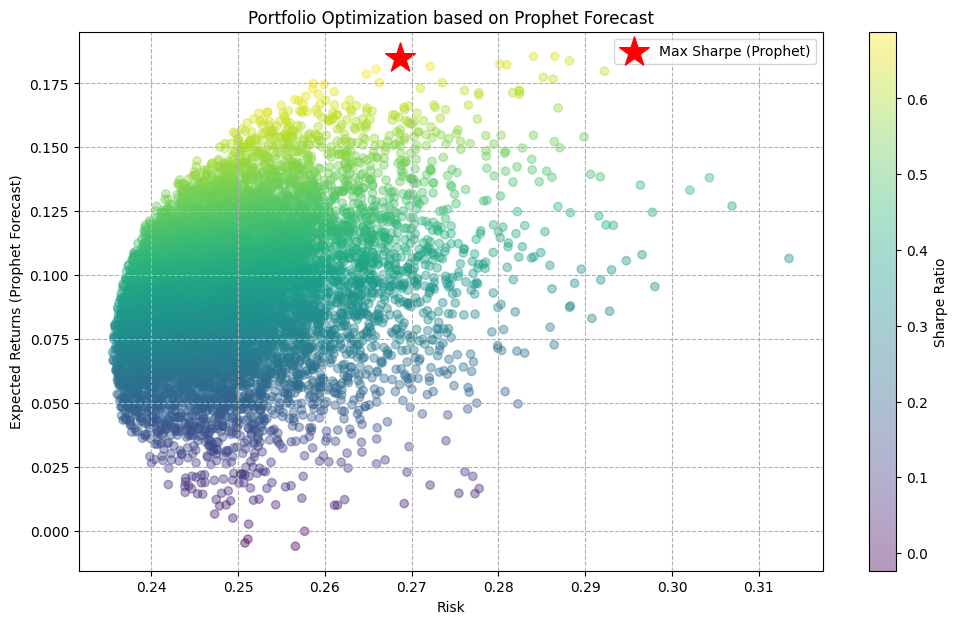

In [39]:
# Prophet 결과 시각화

plt.figure(figsize=(12,7))

scatter = plt.scatter(prophet_pf['Risk'], prophet_pf['Returns'],
                      c=prophet_pf['Sharpe'], cmap='viridis', alpha=0.4)
plt.colorbar(scatter, label='Sharpe Ratio')

plt.scatter(best_prophet['Risk'], best_prophet['Returns'],
            marker='*', color='red', s=500, label='Max Sharpe (Prophet)')

plt.xlabel('Risk')
plt.ylabel('Expected Returns (Prophet Forecast)')
plt.title('Portfolio Optimization based on Prophet Forecast')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# ARIMA vs Prophet vs LSTM 성능 비교 테이블

In [40]:
# 모델별 평균 MAE / RMSE 계산
comparison = pd.DataFrame({
    'ARIMA_MAE': arima_scores['MAE'],
    'ARIMA_RMSE': arima_scores['RMSE'],
    'Prophet_MAE': prophet_scores['MAE'],
    'Prophet_RMSE': prophet_scores['RMSE'],
    'LSTM_MAE': lstm_scores['MAE'],
    'LSTM_RMSE': lstm_scores['RMSE']
})

print("📊 종목별 모델 성능 비교")
print(comparison)

# 모델별 평균 성능 요약
model_summary = pd.DataFrame({
    'MAE': [
        arima_scores['MAE'].mean(),
        prophet_scores['MAE'].mean(),
        lstm_scores['MAE'].mean()
    ],
    'RMSE': [
        arima_scores['RMSE'].mean(),
        prophet_scores['RMSE'].mean(),
        lstm_scores['RMSE'].mean()
    ]
}, index=['ARIMA', 'Prophet', 'LSTM'])

print("\n📌 모델별 평균 성능 요약")
print(model_summary)

📊 종목별 모델 성능 비교
        ARIMA_MAE  ARIMA_RMSE  Prophet_MAE  Prophet_RMSE  LSTM_MAE  LSTM_RMSE
삼성생명     0.020278    0.027707     0.020529      0.027898  0.021296   0.028808
삼성화재     0.021123    0.028857     0.021154      0.028832  0.022611   0.030554
DB손해보험   0.021077    0.027665     0.021073      0.027670  0.022115   0.028603
현대해상     0.015886    0.021272     0.015859      0.021383  0.016407   0.022004
한화생명     0.017384    0.023372     0.017565      0.023714  0.017411   0.023547

📌 모델별 평균 성능 요약
              MAE      RMSE
ARIMA    0.019149  0.025775
Prophet  0.019236  0.025899
LSTM     0.019968  0.026703


**해석:**

- ARIMA
→ 평균 MAE / RMSE 가장 낮음 → 예측 안정성 최고

- Prophet
→ ARIMA보다 약간 높지만 LSTM보다 안정적

- LSTM
→ 평균 오차 가장 큼